# 1. Conhecendo a Base de Dados

In [0]:
dados = spark.table('workspace.default.dataset_consumo_energia')
dados.show(5, False)

+----------+-------------+-------------+-------+-----------+-------+----------------+-----------+
|data      |dia_da_semana|fim_de_semana|feriado|temperatura|area_m2|numero_moradores|consumo_kwh|
+----------+-------------+-------------+-------+-----------+-------+----------------+-----------+
|2021-01-01|sexta        |nao          |nao    |27.9       |160    |3               |35.59      |
|2021-01-02|sabado       |sim          |nao    |18.4       |60     |4               |27.61      |
|2021-01-03|domingo      |sim          |nao    |30.6       |200    |4               |46.54      |
|2021-01-04|segunda      |nao          |nao    |11.2       |60     |1               |16.33      |
|2021-01-05|terca        |nao          |sim    |22.3       |80     |5               |39.05      |
+----------+-------------+-------------+-------+-----------+-------+----------------+-----------+
only showing top 5 rows


* Verificando cada tipo de Features

In [0]:
dados.printSchema()

root
 |-- data: date (nullable = true)
 |-- dia_da_semana: string (nullable = true)
 |-- fim_de_semana: string (nullable = true)
 |-- feriado: string (nullable = true)
 |-- temperatura: double (nullable = true)
 |-- area_m2: long (nullable = true)
 |-- numero_moradores: long (nullable = true)
 |-- consumo_kwh: double (nullable = true)



* Verificando o Total de Linhas e Colunas

In [0]:
print(f'Total de Linhas : {dados.count()}')
print(f'Total de Colunas : {len(dados.columns)}')

Total de Linhas : 1500
Total de Colunas : 8


* Verificando se existem dados nulos no dataset

In [0]:
from pyspark.sql import functions as f

In [0]:
for coluna in dados.columns:
    print(f'{coluna} -> {dados.filter(f.col(coluna).isNull()).count()}')

data -> 0
dia_da_semana -> 0
fim_de_semana -> 0
feriado -> 0
temperatura -> 0
area_m2 -> 0
numero_moradores -> 0
consumo_kwh -> 0


* Verificando a quantidade de dados duplicados do Dataset

In [0]:
total_duplicados = dados.count() - dados.dropDuplicates().count()

print(f'Total duplicados : {total_duplicados}')

Total duplicados : 0


* Verificando o Describe dos dados numéricos

In [0]:
dados.select('temperatura', 'area_m2', 'numero_moradores', 'consumo_kwh').describe().show()

+-------+-----------------+------------------+------------------+-----------------+
|summary|      temperatura|           area_m2|  numero_moradores|      consumo_kwh|
+-------+-----------------+------------------+------------------+-----------------+
|  count|             1500|              1500|              1500|             1500|
|   mean|25.00586666666664|            120.24| 2.937333333333333|32.04167999999996|
| stddev|4.548134702095043|47.181491379062436|1.4099875645469369|6.201824419342439|
|    min|             10.9|                60|                 1|            11.57|
|    max|             41.8|               200|                 5|            52.25|
+-------+-----------------+------------------+------------------+-----------------+



# 2. Tratando os Dados para Análises Gráficas

* Dropando a data pois não iremos utilizar nesse dataset

In [0]:
dados = dados.drop('data')

In [0]:
dados.show(5,False)

+-------------+-------------+-------+-----------+-------+----------------+-----------+
|dia_da_semana|fim_de_semana|feriado|temperatura|area_m2|numero_moradores|consumo_kwh|
+-------------+-------------+-------+-----------+-------+----------------+-----------+
|sexta        |nao          |nao    |27.9       |160    |3               |35.59      |
|sabado       |sim          |nao    |18.4       |60     |4               |27.61      |
|domingo      |sim          |nao    |30.6       |200    |4               |46.54      |
|segunda      |nao          |nao    |11.2       |60     |1               |16.33      |
|terca        |nao          |sim    |22.3       |80     |5               |39.05      |
+-------------+-------------+-------+-----------+-------+----------------+-----------+
only showing top 5 rows


* Tratando as colunas Fim_de_semana e Feriado - deixando elas em um coluna binária recebendo 0 e 1

In [0]:
dados\
    .groupBy('fim_de_semana').count().show()

dados\
    .groupBy('feriado').count().show()

+-------------+-----+
|fim_de_semana|count|
+-------------+-----+
|          nao| 1071|
|          sim|  429|
+-------------+-----+

+-------+-----+
|feriado|count|
+-------+-----+
|    nao| 1424|
|    sim|   76|
+-------+-----+



In [0]:
dados = dados.replace(
  {
    'sim': "1",
    'nao': "0"
  },
  subset=['fim_de_semana', 'feriado']
)
# Transformando os dados de String para Inteiros
dados = dados.withColumn('fim_de_semana', f.col('fim_de_semana').cast('int'))
dados = dados.withColumn('feriado', f.col('feriado').cast('int'))

* Tratando os dados do Dia_da_semana - para receber valores numéricos ordinais

In [0]:
dados\
    .groupBy('dia_da_semana').count().show()

+-------------+-----+
|dia_da_semana|count|
+-------------+-----+
|        sexta|  215|
|       sabado|  215|
|      domingo|  214|
|      segunda|  214|
|        terca|  214|
|       quarta|  214|
|       quinta|  214|
+-------------+-----+



In [0]:
dados = dados.replace(
  {
    "segunda": "0",
    "terca": "1",
    "quarta": "2",
    "quinta": "3",
    "sexta": "4",
    "sabado": "5",
    "domingo": "6"
  },
  subset=['dia_da_semana']
)
# Transformando os dados de Strings para Inteiros
dados = dados.withColumn('dia_da_semana', f.col('dia_da_semana').cast('int'))

* Fazendo a verificação de como ficou todos os dados

In [0]:
dados.show(5, False)

+-------------+-------------+-------+-----------+-------+----------------+-----------+
|dia_da_semana|fim_de_semana|feriado|temperatura|area_m2|numero_moradores|consumo_kwh|
+-------------+-------------+-------+-----------+-------+----------------+-----------+
|4            |0            |0      |27.9       |160    |3               |35.59      |
|5            |1            |0      |18.4       |60     |4               |27.61      |
|6            |1            |0      |30.6       |200    |4               |46.54      |
|0            |0            |0      |11.2       |60     |1               |16.33      |
|1            |0            |1      |22.3       |80     |5               |39.05      |
+-------------+-------------+-------+-----------+-------+----------------+-----------+
only showing top 5 rows


# 3. Análises Gráficas

* Gerando um BOXPLOT dos valores do consumo de energia - verificar possíveis outliers (se precisa ajustar com o LOG)

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

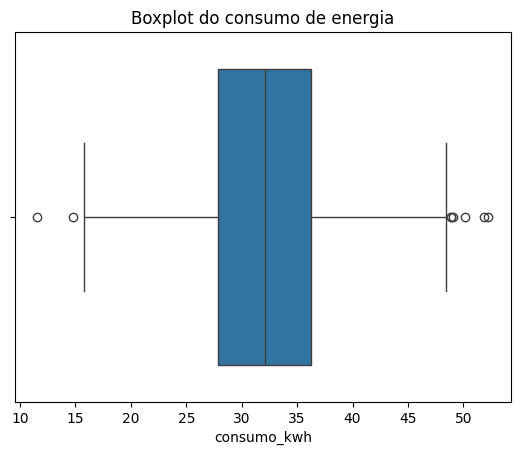

In [0]:
pdf = dados.select(dados.columns)

sns.boxplot(data=pdf.toPandas(), x='consumo_kwh')
plt.title('Boxplot do consumo de energia')
plt.show()

* Visualizando o Histograma dos dados do Consumo de energia - verificar sua frequência

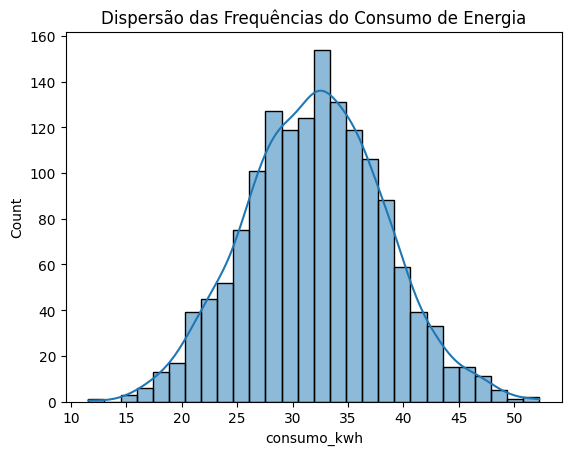

In [0]:
sns.histplot(data=pdf.toPandas(), x='consumo_kwh', kde=True)
plt.title('Dispersão das Frequências do Consumo de Energia')
plt.show()

* Verificando o gráfico da relação das variáveis em relação ao Consumo de Energia

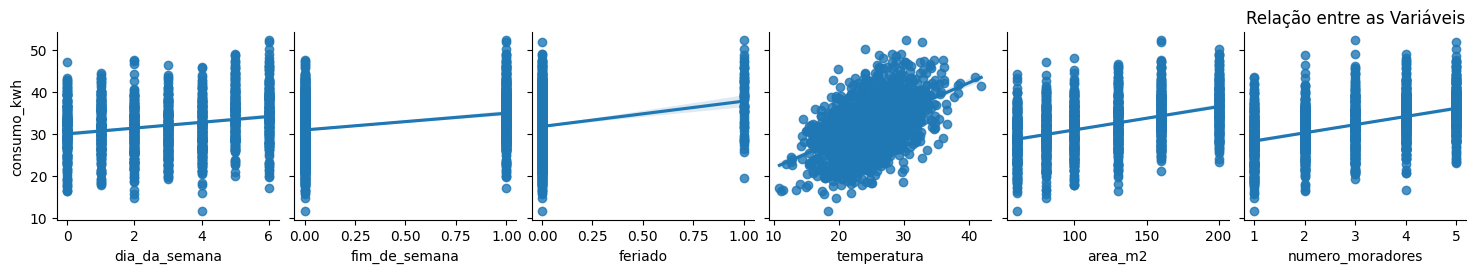

In [0]:
sns.pairplot(data=pdf.toPandas(), y_vars='consumo_kwh', x_vars=['dia_da_semana',
 'fim_de_semana',
 'feriado',
 'temperatura',
 'area_m2',
 'numero_moradores'], kind='reg')
plt.title('Relação entre as Variáveis')
plt.show()

* Verificando o gráfico de correlação dos Dados

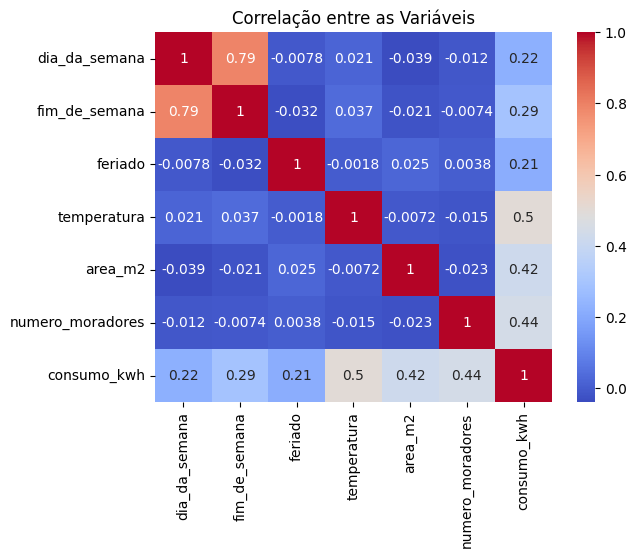

In [0]:
sns.heatmap(data=pdf.toPandas().corr(), annot=True, cmap='coolwarm')
plt.title('Correlação entre as Variáveis')
plt.show()

* Verificando a alta correlação das variáveis fim_de_semana com dia_da_semana isso pode prejudicar o modelo, comisso iremos dropar o dia_da_semana - pois se um está indicando que é final de semana , não precisamos de uma outra variável indicando o dia da semana

In [0]:
dados = dados.drop('dia_da_semana')

# 3. Vetorizando os Dados + Separação para Treinamento

In [0]:
from pyspark.ml.feature import VectorAssembler

* Renomeando a variável alvo - deixando o padrão Label

In [0]:
dados = dados.withColumnRenamed('consumo_kwh', 'label')

In [0]:
X = dados.columns
X.remove('label')
X

['fim_de_semana', 'feriado', 'temperatura', 'area_m2', 'numero_moradores']

* Aplicando a Vetorização nos dados - deixando todas as colunas vetorizadas e recebendo o nome de Features

In [0]:
assembler = VectorAssembler(inputCols=X, outputCol='features')

dados_vec = assembler.transform(dados).select('features', 'label')

dados_vec.show(5, False)

+------------------------+-----+
|features                |label|
+------------------------+-----+
|[0.0,0.0,27.9,160.0,3.0]|35.59|
|[1.0,0.0,18.4,60.0,4.0] |27.61|
|[1.0,0.0,30.6,200.0,4.0]|46.54|
|[0.0,0.0,11.2,60.0,1.0] |16.33|
|[0.0,1.0,22.3,80.0,5.0] |39.05|
+------------------------+-----+
only showing top 5 rows


* Fazendo a Separação dos Dados de Treino e Teste

In [0]:
treino, teste = dados_vec.randomSplit([0.7, 0.3], seed=42)

In [0]:
print(f'Dados Treino -> {treino.count()}')
print(f'Dados Teste -> {teste.count()}')

Dados Treino -> 1102
Dados Teste -> 398


# 4. Modelos de Machine Learning

# Regressão Linear

In [0]:
from pyspark.ml.regression import LinearRegression

In [0]:
lr = LinearRegression()
modelo_lr = lr.fit(treino)

In [0]:
previsoes_lr_treino = modelo_lr.transform(treino)
previsoes_lr_teste = modelo_lr.transform(teste)

* Verificando as Métricas - R² e RMSE

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

In [0]:
evaluator = RegressionEvaluator()

print('Regressão Linear')
print("="*30)
print("Dados de Treino")
print("="*30)
print(f"R²: {evaluator.evaluate(previsoes_lr_treino, {evaluator.metricName: "r2"})}")
print(f"RMSE: {evaluator.evaluate(previsoes_lr_treino, {evaluator.metricName: "rmse"})}")
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print(f"R²: {evaluator.evaluate(previsoes_lr_teste, {evaluator.metricName: "r2"})}" )
print(f"RMSE: { evaluator.evaluate(previsoes_lr_teste, {evaluator.metricName: "rmse"})}")

Regressão Linear
Dados de Treino
R²: 0.7605923031034284
RMSE: 3.040165159370383

Dados de Teste
R²: 0.7782964522293321
RMSE: 2.8980712778608178


# Random Forest

In [0]:
from pyspark.ml.regression import RandomForestRegressor

* Treinando o Modelo de Random Forest

In [0]:
rf = RandomForestRegressor()
modelo_rf = rf.fit(treino)

In [0]:
previsoes_rf_treino = modelo_rf.transform(treino)
previsoes_rf_teste = modelo_rf.transform(teste)

In [0]:
evaluator = RegressionEvaluator()

print('Random Forest')
print("="*30)
print("Dados de Treino")
print("="*30)
print(f"R²: {evaluator.evaluate(previsoes_rf_treino, {evaluator.metricName: "r2"})}")
print(f"RMSE: {evaluator.evaluate(previsoes_rf_treino, {evaluator.metricName: "rmse"})}")
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print(f"R²: {evaluator.evaluate(previsoes_rf_teste, {evaluator.metricName: "r2"})}" )
print(f"RMSE: { evaluator.evaluate(previsoes_rf_teste, {evaluator.metricName: "rmse"})}")

Random Forest
Dados de Treino
R²: 0.705866002611653
RMSE: 3.3697736955615896

Dados de Teste
R²: 0.6783652550957187
RMSE: 3.490633240939091


# 5. Resultados

In [0]:
df_plot = previsoes_lr_teste.select('label', 'prediction').toPandas()

* Plotando o Gráfico dos Dados Reais X Dados Previstos

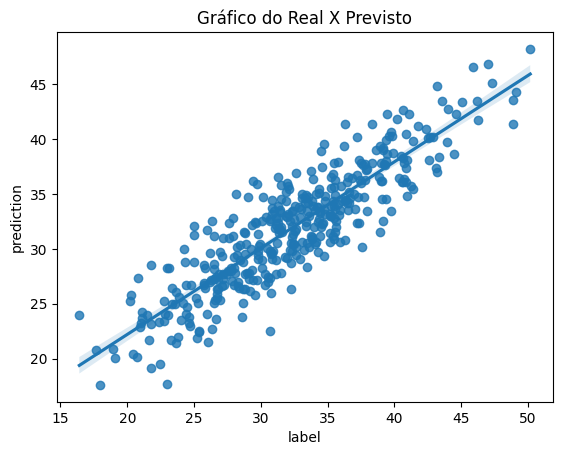

In [0]:
sns.regplot(data=df_plot, x='label', y='prediction')
plt.title('Gráfico do Real X Previsto')
plt.show()

In [0]:
df_plot['residuo'] = df_plot['label'] - df_plot['prediction']

* Plotando o Gráfico do Resíduo - label menos o valor previsto

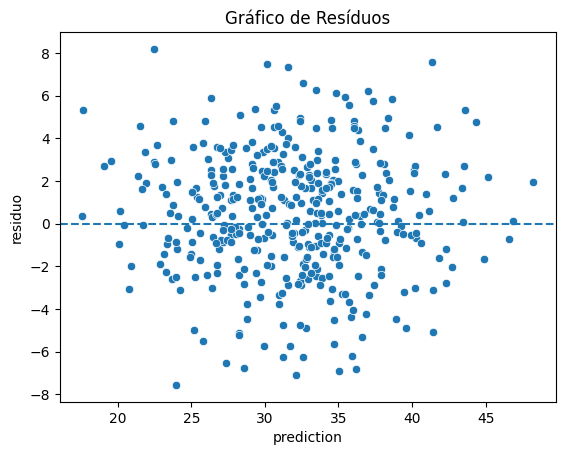

In [0]:
sns.scatterplot(data=df_plot,x='prediction', y='residuo')
plt.title('Gráfico de Resíduos')
plt.axhline(0, linestyle='--')
plt.show()